# Reading eve.json with python

Let's (interactively) explore Suricata eve.json. Modern programming languages provide a rather impressive toolbox for exploring data, without needing any infrastructure investments. Spinning up an Elasticsearch instance can be an overkill when you are analyzing a simple log file. Furthermore, writing custom code can provide more flexibility when exploring the data.

Python has a "batteries included" approach, which means that modules mostly abstract the implementation details. In other words, you do not need to be a professional programmer. Simply unerstanding basic programming concepts and python modules is enough to effenctively analyze data.

## Reading a simple log file line by line

This vagrant folder has an example log file generated from singlehost instance. However, the path is different if you are runnig the notebook directly on host. It does not matter which way you do it. But we can define it only once and then flip the value based on use-case. If you change `VAGRANT` global variable to `true`, then the proceeding code will attempt to load example log file from vagrant mounted volume.

In [59]:
VAGRANT = False
EVE = "/vagrant/eve.json" if VAGRANT else "./eve.json"

Reading a file in python is simple. `with` keyword opens a file handle and ensures that it is properly closed afterwards. `rb` sets the file handle mode to *read* and *binary* (better for interoperativity between operating systems, as linux and windows file handles are different). Finally, `eve` variable exposes an python object that lets us use python methods. Following example opens a suricata eve.json file handle and reads a single line from the beginning.

In [60]:
with open(EVE, 'rb') as eve:
    data = eve.readline()
print(data)

b'{"timestamp":"2020-02-04T11:30:04.384291+0000","flow_id":1699148482796835,"in_iface":"enp0s3","event_type":"dns","src_ip":"10.0.2.15","src_port":42115,"dest_ip":"10.0.2.3","dest_port":53,"proto":"UDP","dns":{"type":"query","id":59061,"rrname":"raw.githubusercontent.com","rrtype":"A","tx_id":0},"host":"CDMCS"}\n'


Note that the line is currently a raw byte array. We need to decode it and load as JSON document to be able to access structured data inside it.

### Decoding a json object

In [61]:
import json
structured_data = json.loads(data)

In [62]:
structured_data

{'timestamp': '2020-02-04T11:30:04.384291+0000',
 'flow_id': 1699148482796835,
 'in_iface': 'enp0s3',
 'event_type': 'dns',
 'src_ip': '10.0.2.15',
 'src_port': 42115,
 'dest_ip': '10.0.2.3',
 'dest_port': 53,
 'proto': 'UDP',
 'dns': {'type': 'query',
  'id': 59061,
  'rrname': 'raw.githubusercontent.com',
  'rrtype': 'A',
  'tx_id': 0},
 'host': 'CDMCS'}

In [63]:
event_type = structured_data['event_type']
print("event type is:", event_type)

event type is: dns


### Handling broken documents

It is rather common to encounter broken documents while parsing log files. Normally, a python script might throw an `Exception` which would terminate the script. Not ideal when you have to restart your script after a crash. Thus, wrapping these sections in `try-except` block may be a good idea.

In [64]:
try:
    structured_data = json.loads(data)
except json.JSONDecodeError as e:
    # logic for handling the error
    pass

### Writing a generator function

Reading log files line by line may be a good idea with larger datasets. We can achieve that by combining the principles from prior cells. However, we still have a problem - code that actually uses decoded data would have to be placed inside the function. We cannot use `return` keyword, as it would simply exit the function after reading first line. And we don't want to read every line into memory, as the file could be quite large. However we still want a self-contained function that is only meant to give us eve objects line-by-line, whereas actual processing would take place afterwards.

Solution is to create a `generator` object with `yield` instead of `return`. Simply put, unline `iterator` a `generator` does not attempt to access the next line until a caller tries to pull it. Note that opened file handle is already an `iterator`, allowing us to loop over the lines. However, each loop iteration blocks until caller consumes the message.

In [66]:
def readEveLineByLine(path=EVE):
    with open(path, "rb") as eve:
        for line in eve: 
            try:
                # Here we should have code that processes decoded data if we did not use a generator
                yield json.loads(line)
            except json.JSONDecodeError as e:
                # simply skip broken messages
                next

This function can now be used as iterator. However, we no longer need to worry about opening a file, reading it line by line, decoding json (and handline exceptions), etc. We can simply work with decoded python dictionaries.

This `iterator` counts the total number of events in log file and the number of alerts (which required json decoding). However, it wraps around our `generator`, so there's no need to worry about input logic.

In [71]:
count = 0
alerts = 0
for line in readEveLineByLine():
    count += 1
    if line["event_type"] == "alert": 
        alerts += 1
print(alerts, "/", count)

33 / 314


## Reading the log file in memory

Reading files line by line vs loading everything into memory is a tradeoff between memory usage and IO speed. Loading everything to memory may be a good idea if dataset is small or you have large amount of memory at hand. After all, chances are you would be using a database if data volume was large.

Python file reader already provides `readlines()` method for doing that.

In [86]:
with open(EVE, 'rb') as eve:
    data = eve.readlines()
print(len(data))

314


### List comprehensions

Suppose we wanted to decode all messages loaded into memory. To do that we would need to:
1. Create a new empty list;
2. Iterate over each data element;
3. For each element:
    1. decode element as JSON object;
    2. append decoded element to the new list;

In [87]:
newlist = []
for item in data:
    decoded = json.loads(item)
    newlist.append(decoded)
print(len(newlist))

314


Python has a built-in concept for handling this common pattern, called **list comprehension**. Simply put, it allows us to implement this logic with a single line of code.

In [88]:
newlist = [ json.loads(item) for item in data ]
print(len(newlist))

314


This allows us to extract values from each object while keeping overall number of code lines small. Suppose we wanted to extract `alert` data if it exists in a document.

In [90]:
newlist = [ item["alert"] for item in newlist if "alert" in item ]
print(len(newlist))

33


Note that we need to check for an existence of dictionary keys. Otherwise python would throw an exception.

In [92]:
print(newlist[0])

{'action': 'allowed', 'gid': 1, 'signature_id': 2210056, 'rev': 1, 'signature': 'SURICATA STREAM bad window update', 'category': 'Generic Protocol Command Decode', 'severity': 3}


### Putting it together

This function combines core concepts covered so far. Note that this time we use `return` instead of `yield` as this function is not meant to be iterated over.

In [93]:
def readEveAllInMem(path=EVE):
    with open(path, "rb") as eve:
        data = eve.readlines()
    data = [json.loads(d) for d in data]
    return data

In [94]:
data = readEveAllInMem()
print(data[0])

{'timestamp': '2020-02-04T11:30:04.384291+0000', 'flow_id': 1699148482796835, 'in_iface': 'enp0s3', 'event_type': 'dns', 'src_ip': '10.0.2.15', 'src_port': 42115, 'dest_ip': '10.0.2.3', 'dest_port': 53, 'proto': 'UDP', 'dns': {'type': 'query', 'id': 59061, 'rrname': 'raw.githubusercontent.com', 'rrtype': 'A', 'tx_id': 0}, 'host': 'CDMCS'}


## String formatting

One of the simplest things we could do is to reformat each message according to some pattern. Suppose we wanted to turn each eve entry into less informative, but more human-readable fast record.

You may be familiar with basic string concatenation.

In [121]:
"first" + ":" + "second"

'first:second'

It's simple, but can become quite messy with complex cases and long variable names. Furthermore, changing the message format would be difficult afterwards. Many languages, like python allow you to define a template string with placeholders to make this syntax a bit more clear. In the following example `%s` is dynamically replaced by the argument `second`.

In [122]:
var = "second"
'first:%s' % var

'first:second'

Python has a newer syntax for that which is a usable method for every string object.

In [123]:
var = "second"
"first:{}".format(var)

'first:second'

### Formatting eve messages

In [124]:
alerts = []
i = 0
for line in readEveLineByLine():
    if "event_type" in line and line["event_type"] == "alert":
        flattened = "{} {} {} -> {} {} {}".format(
            line["timestamp"], 
            line["src_ip"], 
            line["src_port"],
            line["dest_ip"], 
            line["dest_port"], 
            line["alert"]["signature"]
        )
        alerts.append(flattened)
alerts[:25]

['2020-02-04T11:31:30.502586+0000 10.0.2.15 50790 -> 104.18.123.25 443 SURICATA STREAM bad window update',
 '2020-02-04T11:31:30.531078+0000 10.0.2.15 50790 -> 104.18.123.25 443 SURICATA STREAM bad window update',
 '2020-02-04T11:32:08.083450+0000 10.0.2.15 49516 -> 10.0.2.3 53 CDMCS: DNS request for Facebook',
 '2020-02-04T11:32:08.083209+0000 10.0.2.15 44169 -> 10.0.2.3 53 CDMCS: DNS request for Facebook',
 '2020-02-04T11:32:08.128233+0000 10.0.2.3 53 -> 10.0.2.15 44169 CDMCS: DNS request for Facebook',
 '2020-02-04T11:32:08.159384+0000 10.0.2.3 53 -> 10.0.2.15 49516 CDMCS: DNS request for Facebook',
 '2020-02-04T11:32:08.428289+0000 10.0.2.15 37934 -> 31.3.245.133 80 CDMCS: Listed UA seen',
 '2020-02-04T11:32:08.428289+0000 10.0.2.15 37934 -> 31.3.245.133 80 ET POLICY curl User-Agent Outbound',
 '2020-02-04T11:32:08.428547+0000 31.3.245.133 80 -> 10.0.2.15 37934 GPL ATTACK_RESPONSE id check returned root',
 '2020-02-04T11:32:08.415724+0000 104.154.89.105 443 -> 10.0.2.15 58068 CDMCS

## Aggregating data
### Count unique alerts with severity values
We can do various things. For example, track unique seen alerts with the respective severity.

In [125]:
data = readEveAllInMem()
data = [d for d in data if "alert" in d["event_type"]]
seen = {}
for d in data:
    sig = d["alert"]["signature"]
    if sig not in seen:
        seen[sig] = d["alert"]["severity"]

In [126]:
seen

{'SURICATA STREAM bad window update': 3,
 'CDMCS: DNS request for Facebook': 1,
 'CDMCS: Listed UA seen': 1,
 'ET POLICY curl User-Agent Outbound': 2,
 'GPL ATTACK_RESPONSE id check returned root': 2,
 'CDMCS TLS Self Signed Certificate': 3}

### implement an alert counter.

In [128]:
data = readEveAllInMem()
data = [d for d in data if "alert" in d["event_type"]]
seen = {}
for d in data:
    sig = d["alert"]["signature"]
    if sig in seen:
        seen[sig] += 1
    else:
        seen[sig] = 1

In [129]:
seen

{'SURICATA STREAM bad window update': 2,
 'CDMCS: DNS request for Facebook': 10,
 'CDMCS: Listed UA seen': 5,
 'ET POLICY curl User-Agent Outbound': 5,
 'GPL ATTACK_RESPONSE id check returned root': 5,
 'CDMCS TLS Self Signed Certificate': 6}

### Formatting aggregations as dataframes

Python dictionaries and lists can be a bit difficult to work with on human-readability front. Presenting one in a report might not work out well. Luckily, there is one tool from data science toolbox that helps us out - dataframes. Python implements them through `pandas` package that must be installed separately via `pip`.

In [150]:
import pandas as pd
df = pd.DataFrame()
df["signature"] = seen.keys()
df["count"] = seen.values()

In [151]:
df

,signature,count
0,SURICATA STREAM bad window update,2
1,CDMCS: DNS request for Facebook,10
2,CDMCS: Listed UA seen,5
3,ET POLICY curl User-Agent Outbound,5
4,GPL ATTACK_RESPONSE id check returned root,5
5,CDMCS TLS Self Signed Certificate,6


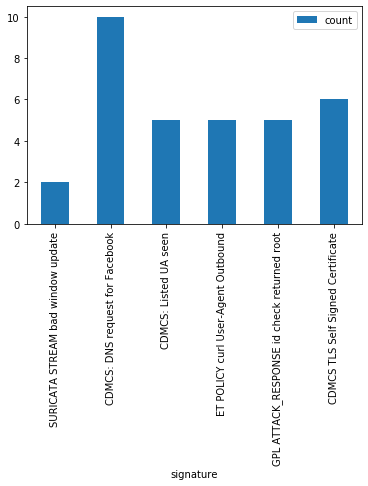

In [155]:
df.plot.bar(x='signature', y='count')

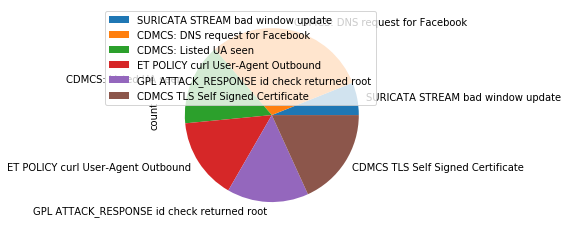

In [156]:
#df.index = df.signature
df.plot.pie(x='signature', y='count', labels=df.signature)

### Time-series plotting

Following example parses the timestamp of each message, splits a dictionary by suricata event type, and assigns each message to one of 24 bins (for every hour of the day). 

In [157]:
import datetime as dt
events = {}
for line in readEveLineByLine():
    if line["event_type"] == "stats":
        continue
        
    t = line["timestamp"]
    t = dt.datetime.strptime(t, '%Y-%m-%dT%H:%M:%S.%f%z')
    
    if t.date() < dt.datetime.today().date() or t.date() > dt.datetime.today().date():
        continue
        
    evType = line["event_type"]

    eventBin = t.hour
    if evType not in events:
        events[evType] = [0 for x in range(24)]
    else:
        events[evType][eventBin] += 1

Then we can plot it in time.

In [158]:
import matplotlib.pyplot as plt

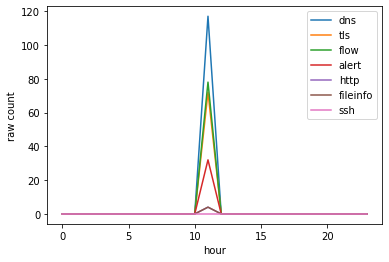

In [159]:
for k, v in events.items():
    plt.plot(v, label=k)

plt.xlabel('hour')
plt.ylabel('raw count')
plt.legend()